# Analyse Votums
Do some data wrangling

In [1]:
import pandas as pd
import json
from pathlib import Path
import utils
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

## Load and Prepare data

In [2]:
csv_path = Path('../export/csv_for_infographics')

In [3]:
df_votum_raw = pd.concat([
    pd.read_csv(Path('../export/votum/votum_0.csv')),
    pd.read_csv(Path('../export/votum/votum_1.csv'))
])

# Remove non members (mostly former members who are now in the Regierungsrat)
df_votum_raw = df_votum_raw[df_votum_raw.ismember == True]

# Typecast
df_votum_raw['sitzung_date'] = pd.to_datetime(df_votum_raw['sitzung_date'])

# Remove empty texts
df_votum_raw = df_votum_raw[df_votum_raw.text.notna()]

# Calculate Amtsjahr (Amtsjahr 2020 = 1.5.2020 - 30.4.2021)
df_votum_raw['year'] = df_votum_raw['sitzung_date'].dt.year
df_votum_raw['month'] = df_votum_raw['sitzung_date'].dt.month
df_votum_raw['session'] = df_votum_raw.apply(lambda row: row['year'] if row['month'] > 5 else row['year'] - 1, axis=1)

# Replace CVP with Die Mitte
df_votum_raw.loc[df_votum_raw.partei.str.lower() == 'cvp', 'partei'] = "Die Mitte"

with open(Path('../export/mitglieder.json'), encoding='utf-8') as f:
    kantonsrat = json.load(f)

# Typecast
utils.kantonsrat_to_datetime(kantonsrat)

print("Stand: %s" % df_votum_raw['sitzung_date'].max())

Stand: 2022-03-28 00:00:00


In [4]:
# Calculate, how many m and w where in Kantonsrat at that time. Reference day: 1. 7. 20XX
dtx = []
for year in range(df_votum_raw['sitzung_date'].min().year, df_votum_raw['sitzung_date'].max().year + 1):

    dt = datetime.datetime(year, 7, 1)
    df = utils.kantonsrat_as_dataframe(kantonsrat, dt)
    df['year'] = year
    dtx.append(df)

df = pd.concat(dtx)

# Remove Präsidents
df = df[df.funktion.isna()]

df_ratsmitglieder_per_year_party = pd.pivot_table(df, index=['party', 'year'], columns='geschlecht', values='name', aggfunc='count').reset_index()
df_ratsmitglieder_per_year_party = df_ratsmitglieder_per_year_party.fillna(0)

df_ratsmitglieder_per_year = df_ratsmitglieder_per_year_party.groupby('year').sum().reset_index()

## Overview m/w in Parties as of today

<AxesSubplot:xlabel='party'>

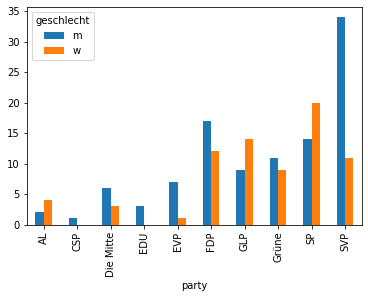

In [5]:
df = utils.kantonsrat_as_dataframe(kantonsrat, datetime.datetime(2022, 1, 1))

# Remove Presidents
df = df[df.funktion.isna()]

df = pd.pivot_table(df, index='party', columns='geschlecht', values='name', aggfunc='count')
#df['w%'] = round(df['w'] / df.sum(axis=1) * 100, 1)
#df['w%'].plot.bar()
df.plot.bar()


## How many times did m/w talk?

In [6]:
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum_pivot = pd.pivot_table(df_votum, index='session', columns='geschlecht', values='name', aggfunc='count').reset_index()

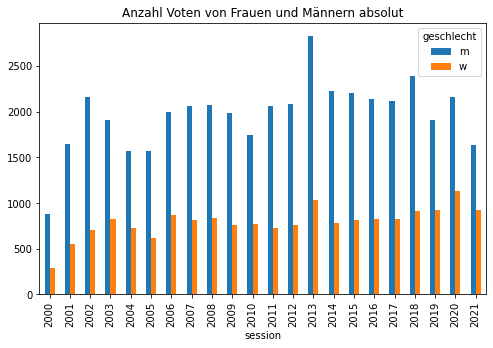

In [7]:
# Do it absolut, plain, in your face way without thinking, but writing a very long comment. Actually this is just a test if someone reads my scripts. If so, write a hello at simon.huwiler@nzz.ch
df_votum_pivot[['m', 'w', 'session']].set_index('session').plot.bar(figsize=(8, 5), title='Anzahl Voten von Frauen und Männern absolut')

# Store as CSV
df_votum_pivot[['m', 'w', 'session']].set_index('session').to_csv(csv_path / 'voten_m_w_absolut.csv')

[csv Voten m/w absolut herunterladen](../export/csv_for_infographics/voten_m_w_absolut.csv)

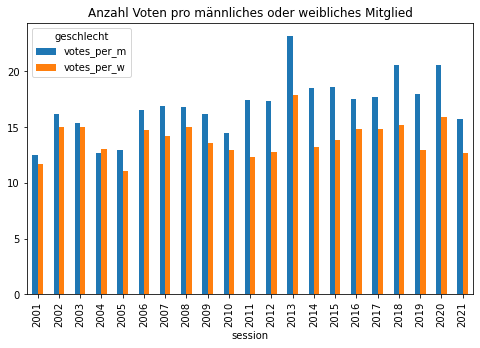

In [8]:
# Concat
df_res = df_votum_pivot.merge(df_ratsmitglieder_per_year, left_on = 'session', right_on = 'year', suffixes=('_v', '_r'))

# Votes per w/m
df_res['votes_per_m'] = round(df_res['m_v'] / df_res['m_r'], 1)
df_res['votes_per_w'] = round(df_res['w_v'] / df_res['w_r'], 1)

df_res.set_index('session', inplace=True)

df_res.drop(columns=['year'], inplace=True)

df_res[['votes_per_m', 'votes_per_w']].plot.bar(figsize=(8, 5), title='Anzahl Voten pro männliches oder weibliches Mitglied')

# Store as CSV
df_res[['votes_per_m', 'votes_per_w']].to_csv(csv_path / 'voten_m_w_relative.csv')


In [9]:
df_res['abweichung'] = df_res['votes_per_m'] - df_res['votes_per_w']
df_res[['votes_per_m', 'votes_per_w']]

geschlecht,votes_per_m,votes_per_w
session,,
2001,12.5,11.7
2002,16.2,15.0
2003,15.4,15.0
2004,12.7,13.0
2005,12.9,11.1
2006,16.5,14.7
2007,16.9,14.2
2008,16.8,15.0
2009,16.2,13.6


<AxesSubplot:xlabel='session'>

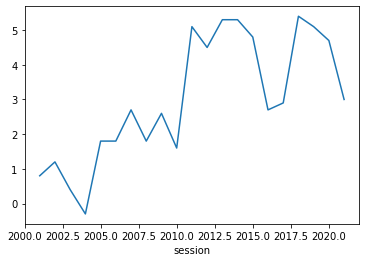

In [10]:
df_res['abweichung'].plot()

[csv Voten m/w relativ herunterladen](../export/csv_for_infographics/voten_m_w_relative.csv)

## m/w per Party

In [11]:
# Remove Presidents
df = df_votum_raw[df_votum_raw.funktion.isna()].copy()

df = pd.pivot_table(df, index=['partei', 'session'], columns='geschlecht', values='name', aggfunc='count').reset_index()
df.rename(columns={'w': 'votum_w', 'm': 'votum_m'}, inplace=True)

# Add Mitglieder Count
df = df.merge(df_ratsmitglieder_per_year_party, how='left', left_on=['session', 'partei'], right_on=['year', 'party'])
df.rename(columns={'w': 'count_w', 'm': 'count_m'}, inplace=True)

# Sum
df['votum_sum'] = df['votum_m'] + df['votum_w']
df['count_sum'] = df['count_m'] + df['count_w']

df = df.fillna(0)

# Drop count_sum 0: It is possible, that there are male or female votes but no male or female councilor in the dataset. How? How many councilor they where in the council
# is determend at reference day. Its possible that was a shift in seats. Look at Andrea Widmer Graf. Her second period was from 11.2006 - 20.05.2007, she will not be counted as 
# a female member in year 2006 nor 2007
df = df[df.count_sum > 0]

# %
df['m_capita'] = df['votum_m'] / df['count_m']
df['w_capita'] = df['votum_w'] / df['count_w']
df['diff%'] = df['m_capita'] / df['w_capita'] - 1
df['diff'] = df['m_capita'] - df['w_capita']
df = df.fillna(0)

Text(0.5, 1.02, 'Wortmeldungen, relative Unterschiede Frauen zu Männer pro Kopf und Partei')

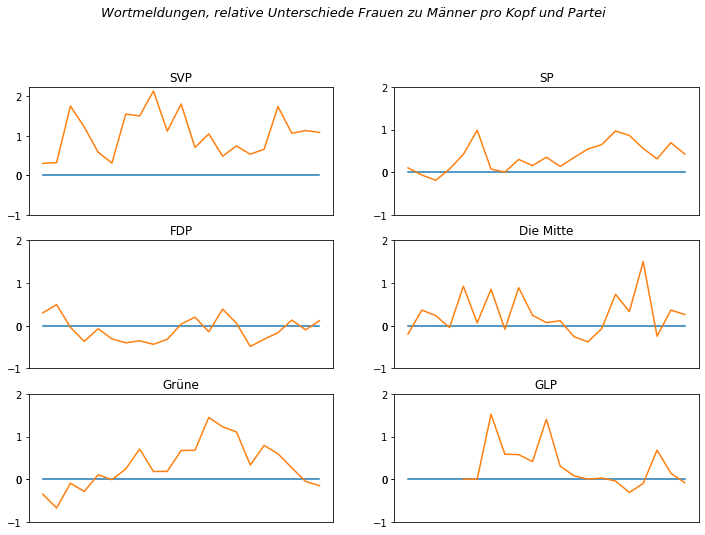

In [12]:
# Abweichung alle
df2 = pd.pivot_table(df, index='session', columns='party', values='diff%')
df2['baseline'] = 0

df_list = []
for partei in ['SVP', 'SP', 'FDP', 'Die Mitte', 'Grüne', 'GLP']:
    df_list.append({'title': partei, 'df': df2[['baseline', partei]]})

nrow=3
ncol=2
fig, axes = plt.subplots(nrow, ncol, figsize=(12,8))

# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        df_list[count]['df'].plot(ax=axes[r,c], title=df_list[count]['title'], legend=False, xticks=[], xlabel='', yticks=[-1, 0, 0, 1, 2])
        #df_list[count]['df'].plot(ax=axes[r,c], title=df_list[count]['title'], legend=False, xticks=[], xlabel='', yticks=[-20, -10, 0, 10, 20])
        count+=1


# general title
plt.suptitle("Wortmeldungen, relative Unterschiede Frauen zu Männer pro Kopf und Partei", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)

In [13]:
df2[['SVP', 'SP', 'FDP', 'Die Mitte', 'Grüne', 'GLP']].to_csv(Path('../export/csv_for_infographics/wortmeldungen_pro_partei.csv'))

## Seit 2019

<AxesSubplot:title={'center':'Voten per Geschlecht und Kopf seit 2019'}, xlabel='partei'>

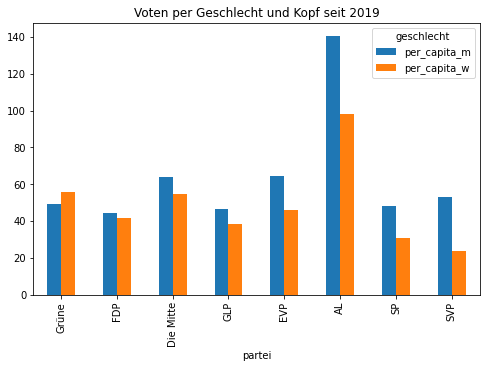

In [17]:
# Nur aktueller Kantonsrat (>=2019). Stichtag Zusammensetzung: 2021.07.01.
df2 = df[df.session >= 2019].groupby('partei').agg({'votum_m': 'sum', 'votum_w': 'sum'})

# Get Kantonsrat
df_kantonsrat = utils.kantonsrat_as_dataframe(kantonsrat, datetime.datetime(2021, 7, 1))
df_kantonsrat = pd.pivot_table(df_kantonsrat, index='party', columns='geschlecht', values='name', aggfunc='count')
df_kantonsrat = df_kantonsrat.fillna(0)

# Merge
df2 = df2.reset_index().merge(df_kantonsrat.reset_index(), how='left', left_on = 'partei', right_on='party')

# Calc per Capita
df2['per_capita_m'] = round(df2['votum_m'] / df2['m'], 1)
df2['per_capita_w'] = round(df2['votum_w'] / df2['w'], 1)
df2['abweichung'] = df2['per_capita_m'] / df2['per_capita_w']

df2 = df2[df2.w > 0]

df2 = df2.set_index('partei')

df2 = df2.sort_values('abweichung')

df2[['per_capita_m', 'per_capita_w']].plot.bar(figsize=(8, 5), title='Voten per Geschlecht und Kopf seit 2019')

In [15]:
df2.to_csv(csv_path / 'votes_per_partei_und_geschlecht.csv')

In [16]:
df2

geschlecht,votum_m,votum_w,party,m,w,per_capita_m,per_capita_w,abweichung
partei,,,,,,,,
Grüne,540.0,555.0,Grüne,11.0,10.0,49.1,55.5,0.884685
FDP,749.0,500.0,FDP,17.0,12.0,44.1,41.7,1.057554
Die Mitte,383.0,164.0,Die Mitte,6.0,3.0,63.8,54.7,1.166362
GLP,466.0,541.0,GLP,10.0,14.0,46.6,38.6,1.207254
EVP,452.0,46.0,EVP,7.0,1.0,64.6,46.0,1.404348
AL,422.0,295.0,AL,3.0,3.0,140.7,98.3,1.431333
SP,672.0,611.0,SP,14.0,20.0,48.0,30.6,1.568627
SVP,1797.0,258.0,SVP,34.0,11.0,52.9,23.5,2.251064


## Unterschiedliche Textlänge?
Erkenntnis: Frauen und Männer reden gleich lange. Wohl wegen begrenzter Redezeit?

In [ ]:
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum = df_votum.reset_index(drop=True)

# Count words
#df_votum['wordcount'] = df_votum['text'].apply(lambda x: len(x.split()))
df_votum['wordcount'] = df_votum['text'].apply(lambda x: len(x))

df_votum = df_votum.groupby('geschlecht').agg({
    'wordcount': 'sum',
    'name': 'count'
})

df_votum['l'] = round(df_votum['wordcount'] / df_votum['name'])

df_votum

## The Speakers...

In [ ]:
df_votum = df_votum_raw.copy()

df_votum = df_votum[df_votum.session == 2021]

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum = df_votum.groupby(['name', 'vorname', 'geschlecht']).agg({'text': 'count'}).reset_index().sort_values('text', ascending=False)

df_votum = pd.concat([df_votum.head(10), df_votum.tail(10)])

c = list(df_votum['geschlecht'].apply(lambda x: 'red' if x == 'm' else 'green'))
df_votum.plot(kind='barh', x='name', y='text', color=c, figsize=(5, 8), title='Am meisten und wenigsten Voten 2021')

#df_votum.head()

In [ ]:
df_votum.to_csv(csv_path / 'top_flop_speakers_2021.csv', index=False)
df_votum

[csv top/flop speakers herunterladen](../export/csv_for_infographics/top_flop_speakers_2021.csv)

## Frauen im Durchschnitt

In [ ]:
df_votum = df_votum_raw.copy()

df_votum = df_votum[df_votum.session >= 2018]

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

# Nur Frauen
df_votum = df_votum[df_votum.geschlecht == 'w']

df_votum = df_votum.groupby(['name', 'vorname', 'geschlecht']).agg({'text': 'count'}).reset_index().sort_values('text', ascending=False)

df_votum['_name'] = df_votum.apply(lambda row: "%s %s" % (row['vorname'], row['name']), axis=1)

df_votum = df_votum[['_name', 'text']]

df_votum.rename(columns={'text': 'Anzahl Voten'}, inplace=True)

df_votum = df_votum.set_index('_name')

median = df_votum['Anzahl Voten'].median()

df_votum[df_votum['Anzahl Voten'].between(median - 2, median + 2)]

In [ ]:
df_votum.plot.bar(figsize=(15, 8), title='Anzahl Voten')

In [ ]:
print("Mean: %s" % df_votum['Anzahl Voten'].mean())
print("Median: %s" % df_votum['Anzahl Voten'].median())

## Talking Parties...

In [ ]:
# Absolut
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum = df_votum.groupby('partei').agg({'name': 'count'}).sort_values('name')
df_votum.plot.bar(title='Welche Partei spricht wie oft (absolut)?')

In [ ]:
# Relative per strength
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

dtx = []
for year in range(df_votum['sitzung_date'].min().year, df_votum['sitzung_date'].max().year + 1):

    dt = datetime.datetime(year, 7, 1)
    df = utils.kantonsrat_as_dataframe(kantonsrat, dt)
    df['year'] = year
    dtx.append(df)

df = pd.concat(dtx)

# Remove Präsidents
df = df[df.funktion.isna()]

df = pd.pivot_table(df, columns='party', values='name', aggfunc='count').reset_index(drop=True)
df.loc[0, 'name'] = 'members'

df_votum = df_votum.groupby('partei').agg({'name': 'count'}).T.reset_index(drop=True)
df_votum.loc[0, 'name'] = 'votes'

# Combine both datasets, set index and transform
df = pd.concat([df, df_votum])
df = df.set_index('name').T
df = df.fillna(0)

# Calculate Vote per Member
df['per_member'] = round(df['votes'] / df['members'], 1)

df.sort_values('per_member', ascending=False)['per_member'].plot.bar(title='Welche Partei wie oft spricht, nach Parteistärke')

In [ ]:
df.sort_values('per_member', ascending=False)

## Wie findet eine Debatte statt?

In [ ]:
# fix Date: If "Vormittag" or "Nachmittag", add Time
df_votum = df_votum_raw.copy()

def add_date(row):
    if 'Vormittag' in row['dokument_titel']:
        return row['sitzung_date'].replace(hour=8)

    if 'Nachmittag' in row['dokument_titel']:
        return row['sitzung_date'].replace(hour=14)

    if 'Abend' in row['dokument_titel']:
        return row['sitzung_date'].replace(hour=19)

    if 'Nacht' in row['dokument_titel']:
        return row['sitzung_date'].replace(hour=23)

    return row['sitzung_date']

df_votum['sitzung_date2'] = df_votum.apply(add_date, axis=1)

In [ ]:
records = []
for date in df_votum['sitzung_date2'].unique():
    df = df_votum[df_votum.sitzung_date2 == date].reset_index(drop=True)
    for i, row in df.iterrows():
        t = 'the king' if row['funktion'] in ['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'] else row['geschlecht']
        records.append({
            'sitzung_date': date,
            'i': i,
            'type': t,
            'name': "%s %s" % (row['vorname'], row['name'])
        })

In [ ]:
# Test: Replace Date with index
df_sitzung = pd.DataFrame(records)

for i, d in enumerate(df_sitzung.sitzung_date.unique()):
    df_sitzung.loc[df_sitzung.sitzung_date == d, 'group'] = i

In [ ]:
# Filter, if needed
df_sitzung = df_sitzung[df_sitzung.sitzung_date >= '2016-05-01']

In [ ]:
#df_sitzung = pd.DataFrame(records)

size_x = 15
fig, ax = plt.subplots(figsize=(size_x, size_x * 1.41 * 2))
ax.margins(0.05)
for t in df_sitzung.type.unique():
    df = df_sitzung[df_sitzung.type == t]
    #c = '#d64b47' if t == 'the king' else '#24b39c' if t == 'm' else '#6c43c0'
    c = '#c2babd' if t == 'the king' else '#24B39C' if t == 'm' else '#6C43C0'
    #ax.plot(df['i'], df['group'], marker='o', linestyle='', ms=3.3, label=t, color=c)
    ax.plot(df['i'], df['sitzung_date'], marker='o', linestyle='', ms=3.3, label=t, color=c)

ax.legend(numpoints=1, loc='upper right')

ax.yaxis.set_major_locator(mdates.WeekdayLocator(interval=20))
ax.yaxis.set_major_formatter(DateFormatter("%Y-%m"))

plt.title("Wer wann im Kantonsrat spricht", fontsize=25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.margins(0.01)

#plt.show()
plt.savefig(Path('../export/plots/dotplot.png'), dpi=200, bbox_inches='tight')

#df_sitzung.head()

## The same but interactive

In [ ]:
import plotly.express as px
#df_sitzung = pd.DataFrame(records)

fig = px.scatter(df_sitzung,
    x="i", y="group",
    color="type",
    hover_data={"sitzung_date": "|%Y-%m-%d %H:00"},
    width=1200, height=2200,
    color_discrete_sequence=["#c2babd", "#24b39c", "#6c43c0"])

# Change marker size
fig.update_traces(marker=dict(size=4), selector=dict(mode='markers'))

fig.show()

## Wo Frauen wenig/viel gesprochen haben und bei welchen Themen
* Top 10 Sitzungen, bei denen Frauen/Männer am meisten gesprochen haben.
* Von diesen Sitzungen Sitzungsprotokolle exportieren

In [ ]:
# Absolut
df_votum = df_votum_raw.copy()

# Remove all Statements from President, 1. & 2. Vizepresidents
df_votum = df_votum[~df_votum.funktion.isin(['Präsidium', '2. Vizepräsidium', '1. Vizepräsidium'])]

df_votum['sitzung_start'] = pd.to_datetime(df_votum['sitzung_start'])

# Pivot
df_votum = pd.pivot_table(df_votum, index = 'sitzung_start', columns='geschlecht', values='name', aggfunc='count')

df_votum['v'] = round(df_votum['m'] / df_votum['w'], 2)
df_votum['sum'] = df_votum.sum(axis=1)

df_votum = df_votum.sort_values('v')

In [ ]:
df_traktanden = pd.read_csv(Path('../export/traktanden.csv'))
df_traktanden['sitzung'] = pd.to_datetime(df_traktanden['sitzung'])

df_votum_trak = df_votum[df_votum.index >= df_traktanden['sitzung'].min()]

### Bei diesen Traktanden haben *Frauen* am meisten gesprochen

In [ ]:
# Traktanden bei Top 10 w
dates = list(df_votum_trak[df_votum_trak.v <= 1].head(5).index)
list(df_traktanden[df_traktanden.sitzung.isin(dates)]['titel'])

### Bei diesen Traktanden haben *Männer* am meisten gesprochen

In [ ]:
# Traktanden bei Top 10 m
dates = list(df_votum_trak[df_votum_trak.v >= 1].tail(5).index)
list(df_traktanden[df_traktanden.sitzung.isin(dates)]['titel'])